# TP2 - Análise de hiper-parâmetros no PSO
Aluno: Pedro Augusto de Castro e Castro

In [1]:
import random
import math
import matplotlib.pyplot as plt



nv = 10 # número de variáveis
mm = -1 # se for um problema de minização: mm = -1; se for um problema de maximização: mm = 1

bounds = [(-100, 100) for _ in range(nv)]

iterations = 10
particle_size = int(100000 / iterations)    

def objective_function_sphere(xx):
    y = sum([xi ** 2 for xi in xx])
    return y

def objective_function_rastrigin(xx):
    y = 10 * len(xx) + sum([xi ** 2 - 10 * math.cos(2 * math.pi * xi) for xi in xx])
    return y
     

In [2]:
class Particle:
    def __init__(self,bounds):
        self.particle_position=[]                     # posição da partícula
        self.particle_velocity=[]                     # velocidade da partícula
        self.local_best_particle_position=[]          # melhor posição da partícula
        self.fitness_local_best_particle_position= initial_fitness  # valor da função objetivo inicial da partícula com a melhor posição
        self.fitness_particle_position=initial_fitness             # valor da função objetivo inicial da partícula
 
        for i in range(nv):
            self.particle_position.append(random.uniform(bounds[i][0],bounds[i][1])) # gerar uma posição inicial aleatória
            self.particle_velocity.append(random.uniform(-1,1)) # gerar uma velocidade aleatória
 
    def evaluate(self,objective_function):
        self.fitness_particle_position=objective_function(self.particle_position)
        if mm == -1:
            if self.fitness_particle_position < self.fitness_local_best_particle_position:
                self.local_best_particle_position=self.particle_position                  # update o melhor local
                self.fitness_local_best_particle_position=self.fitness_particle_position  # update o fitness do melhor local
        if mm == 1:
            if self.fitness_particle_position > self.fitness_local_best_particle_position:
                self.local_best_particle_position=self.particle_position                  # update o melhor local
                self.fitness_local_best_particle_position=self.fitness_particle_position  # update o fitness do melhor local
 
    def update_velocity(self,global_best_particle_position):
        for i in range(nv):
            r1=random.random()
            r2=random.random()
 
            cognitive_velocity = c1*r1*(self.local_best_particle_position[i] - self.particle_position[i])
            social_velocity = c2*r2*(global_best_particle_position[i] - self.particle_position[i])
            self.particle_velocity[i] = X*(w*self.particle_velocity[i] + cognitive_velocity + social_velocity)
 
    def update_position(self,bounds):
        for i in range(nv):
            self.particle_position[i]=self.particle_position[i]+self.particle_velocity[i]
 
            # checar e arrumar para satisfazer os limites superiores
            if self.particle_position[i]>bounds[i][1]:
                self.particle_position[i]=bounds[i][1]
            # checar e arrumar para satisfazer os limites inferiores
            if self.particle_position[i] < bounds[i][0]:
                self.particle_position[i]=bounds[i][0]

In [3]:
class PSO():
    def __init__(self,objective_function,bounds,particle_size,iterations):
 
        self.fitness_global_best_particle_position=initial_fitness
        self.global_best_particle_position=[]
 
        swarm_particle=[]
        for i in range(particle_size):
            swarm_particle.append(Particle(bounds))
            
        self.A=[]         
        for i in range(iterations):
            for j in range(particle_size):
                swarm_particle[j].evaluate(objective_function)
 
                if mm ==-1:
                    if swarm_particle[j].fitness_particle_position < self.fitness_global_best_particle_position:
                        self.global_best_particle_position = list(swarm_particle[j].particle_position)
                        self.fitness_global_best_particle_position = float(swarm_particle[j].fitness_particle_position)
                if mm ==1:
                    if swarm_particle[j].fitness_particle_position > self.fitness_global_best_particle_position:
                        self.global_best_particle_position = list(swarm_particle[j].particle_position)
                        self.fitness_global_best_particle_position = float(swarm_particle[j].fitness_particle_position)
            for j in range(particle_size):
                swarm_particle[j].update_velocity(self.global_best_particle_position)
                swarm_particle[j].update_position(bounds)
                 
            self.A.append(self.fitness_global_best_particle_position) # grava o melhor fitness
             
             
        #print('Optimal solution:', self.global_best_particle_position)
        print('Valor da função objetivo:', self.fitness_global_best_particle_position)
        #print('Evolutionary process of the objective function value:')
        plt.plot(self.A)        

    def gbest(self):
        return self.fitness_global_best_particle_position
     


In [4]:
#------------------------------------------------------------------------------
if mm == -1:
    initial_fitness = float("inf") # para problemas de minimização
if mm == 1:
    initial_fitness = -float("inf") # para problemas de maximização
    
w = 1.0
X = 1.0
#------------------------------------------------------------------------------  

Valor da função objetivo: 187.8419556044033
Valor da função objetivo: 318.91183574160004
Valor da função objetivo: 360.51376217548943
Valor da função objetivo: 436.07497037700955
Valor da função objetivo: 314.34560728310623
Valor da função objetivo: 195.24077015052617
Valor da função objetivo: 309.07356861636276
Valor da função objetivo: 488.8759947802253
Valor da função objetivo: 243.8227737098543
Valor da função objetivo: 567.4579890630889
Valor da função objetivo: 415.2427737223341
Valor da função objetivo: 233.8406529550969
Valor da função objetivo: 486.20641858214054
Valor da função objetivo: 228.31663147585604
Valor da função objetivo: 403.83182700454927
Valor da função objetivo: 470.87453802641005
Valor da função objetivo: 504.71811227987683
Valor da função objetivo: 261.13932319195266
Valor da função objetivo: 505.7768661157461
Valor da função objetivo: 252.4413204142946
Valor da função objetivo: 277.4919424541772
Valor da função objetivo: 621.789421502915
Valor da função objet

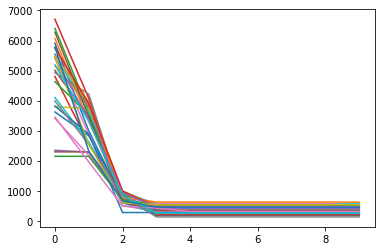

In [12]:
 # Main PSO  - Sphere
c1 = 1.2
c2 = 0.4

all_gbest_sphere = []
for i in range(31):
    var = PSO(objective_function_sphere,bounds,particle_size,iterations)
    all_gbest_sphere.append(var.gbest())    
    if i == 30:
        print('Processo evolucionário do valor da função objetivo:')

mean_sphere = sum(all_gbest_sphere) / len(all_gbest_sphere)
print(f'O valor médio das 31 execuções do PSO para a função sphere foi de: {mean_sphere}')
desv_pad_sphere = math.sqrt(
    sum(
        list(
            map(lambda x: (x - mean_sphere) ** 2, all_gbest_sphere)
        )
    ) / len(all_gbest_sphere))

print(f'O valor do desvio padrão das 31 execuções do PSO para a função sphere foi de: {desv_pad_sphere}')

Valor da função objetivo: 190.78863347422754
Valor da função objetivo: 194.68221399890837
Valor da função objetivo: 357.4403504935633
Valor da função objetivo: 386.1854403368614
Valor da função objetivo: 286.24595719252744
Valor da função objetivo: 457.40577954983894
Valor da função objetivo: 317.4279399767604
Valor da função objetivo: 372.4875451641528
Valor da função objetivo: 238.9050913137798
Valor da função objetivo: 263.7484662345029
Valor da função objetivo: 295.8723309217759
Valor da função objetivo: 353.7754348788069
Valor da função objetivo: 353.73093198563714
Valor da função objetivo: 287.1398194624422
Valor da função objetivo: 319.57879887606526
Valor da função objetivo: 325.2674568521336
Valor da função objetivo: 402.27239861336375
Valor da função objetivo: 323.1591924989816
Valor da função objetivo: 478.58664214162735
Valor da função objetivo: 345.10444415299617
Valor da função objetivo: 396.8746948308238
Valor da função objetivo: 281.1471864354473
Valor da função objetiv

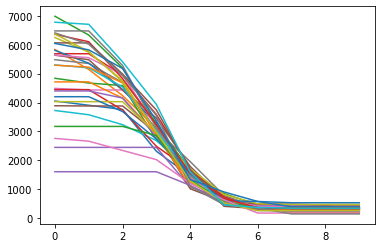

In [6]:
# Main PSO  - Rastrigin
c1 = 0.7
c2 = 0.1 

all_gbest_rastrigin = []
for i in range(31):
    var = PSO(objective_function_rastrigin,bounds,particle_size,iterations)
    all_gbest_rastrigin.append(var.gbest())
    if i == 30:
        print('Processo evolucionário do valor da função objetivo:')
        
mean_rastrigin = sum(all_gbest_rastrigin) / len(all_gbest_rastrigin)
print(f'O valor médio das 31 execuções do PSO para a função rastrigin foi de: {mean_rastrigin}')
desv_pad_rastrigin  = math.sqrt(
    sum(
        list(
            map(lambda x: (x - mean_rastrigin) ** 2, all_gbest_rastrigin)
        )
    ) / len(all_gbest_rastrigin))

print(f'O valor do desvio padrão das 31 execuções do PSO para a função rastrigin  oi de: {desv_pad_rastrigin}')

In [ ]:
# Tunagem dos hyper parametros - tentativa
